In [1]:
import sys
sys.path.append('../Segmentation_UNet')

from model import UNet
from data_module import DataModule

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torchvision.transforms as T
from PIL import Image
import cv2
from pycocotools.coco import COCO
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\DannW\Anaconda3\envs\segmentation_coco_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
checkpoint_path = 'model\model_logs\metriclogs_model01_unet_300_epochs_350\model01_unet_300_epochs_350-epoch=89-val_loss=0.21_checkpoint.ckpt'
model = UNet()
checkpoint = torch.load(checkpoint_path
                        , map_location=torch.device('cuda'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
model = UNet()
model.load_state_dict(torch.load('model\model_logs\metriclogs_model01_unet_300_epochs_350\model01_unet_300_epochs_350.pt'))

<All keys matched successfully>

In [4]:
train_df = pd.read_csv('data/dataset_firstTest/train_100dogs_100cats_100nocatsnodogs/train_for_OutSegmentationModelTest.csv')
train_df = train_df[train_df['label']=='dog']
train_df.head()

image_id        image_path        mask_image_path label  \
100    185250  000000185250.jpg  000000185250_mask.pkl   dog   
101    329219  000000329219.jpg  000000329219_mask.pkl   dog   
102     29393  000000029393.jpg  000000029393_mask.pkl   dog   
103    107226  000000107226.jpg  000000107226_mask.pkl   dog   
104    134112  000000134112.jpg  000000134112_mask.pkl   dog   

     num_elements_of_label_category  
100                               1  
101                               1  
102                               1  
103                               3  
104                               1

## Inference on training dataset

In [19]:
import random
i_sample = random.randint(0,train_df.shape[0])
img = Image.open('data/dataset_firstTest/train_100dogs_100cats_100nocatsnodogs/images/'+train_df['image_path'].iloc[i_sample])
img = (np.array(img)/255).astype('float32')
with open('data/dataset_firstTest/train_100dogs_100cats_100nocatsnodogs/masks/'+train_df['mask_image_path'].iloc[i_sample], 'rb') as f:
    img_mask = pickle.load(f).astype('int8')
mask_oh = (np.arange(2) == img_mask[...,None]).astype(np.float32) 
resized_img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
resized_mask_oh = cv2.resize(mask_oh, (512, 512), interpolation=cv2.INTER_NEAREST)
resized_img_tensor = torch.tensor(resized_img).permute(2,0,1).unsqueeze(0)
resized_mask_oh_tensor = torch.tensor(resized_mask_oh).permute(2, 0, 1).unsqueeze(0)
resized_img_tensor.shape, resized_mask_oh_tensor.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 2, 512, 512]))

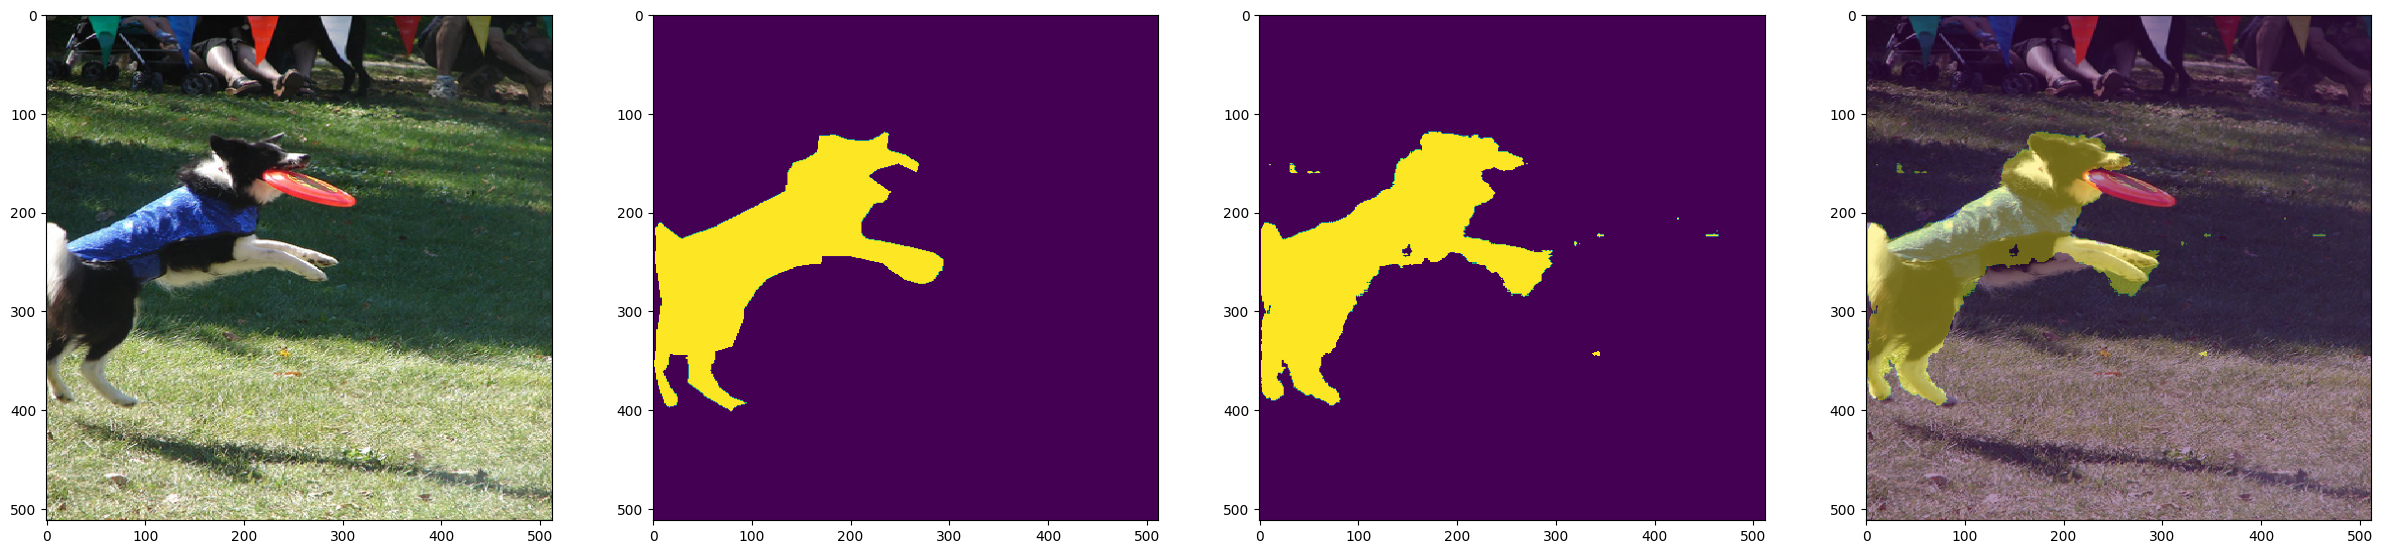

In [20]:
with torch.no_grad():
    output = model(resized_img_tensor.to('cpu'))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,10))
ax1.imshow(resized_img)
ax2.imshow(cv2.resize(img_mask, (512, 512), interpolation=cv2.INTER_NEAREST))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax4.imshow(resized_img)
ax4.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)
plt.show()

In [19]:
output.shape

torch.Size([2, 512, 512])

## Inference on test images (unknown)

In [21]:
import json
labels_dog = json.load(open('data/dataset_firstTest/train_100dogs_100cats_100nocatsnodogs/labels_jsons_fromFiftyone/labels_dog.json'))
labels_dog.keys()
dog_images_df = pd.DataFrame(labels_dog['images'])

In [62]:
dog_images_df.shape

(150, 8)

In [63]:
stop=False
while(stop==False):
    dog_image_sample_df = dog_images_df.sample(1)
    if os.path.isfile(os.path.join('data', 'dataset_firstTest', 'test', dog_image_sample_df['file_name'].iloc[0])):
        img = Image.open('data/dataset_firstTest/train_100dogs_100cats_100nocatsnodogs/images/'+dog_image_sample_df['file_name'].iloc[0])
        stop=True


KeyboardInterrupt: 

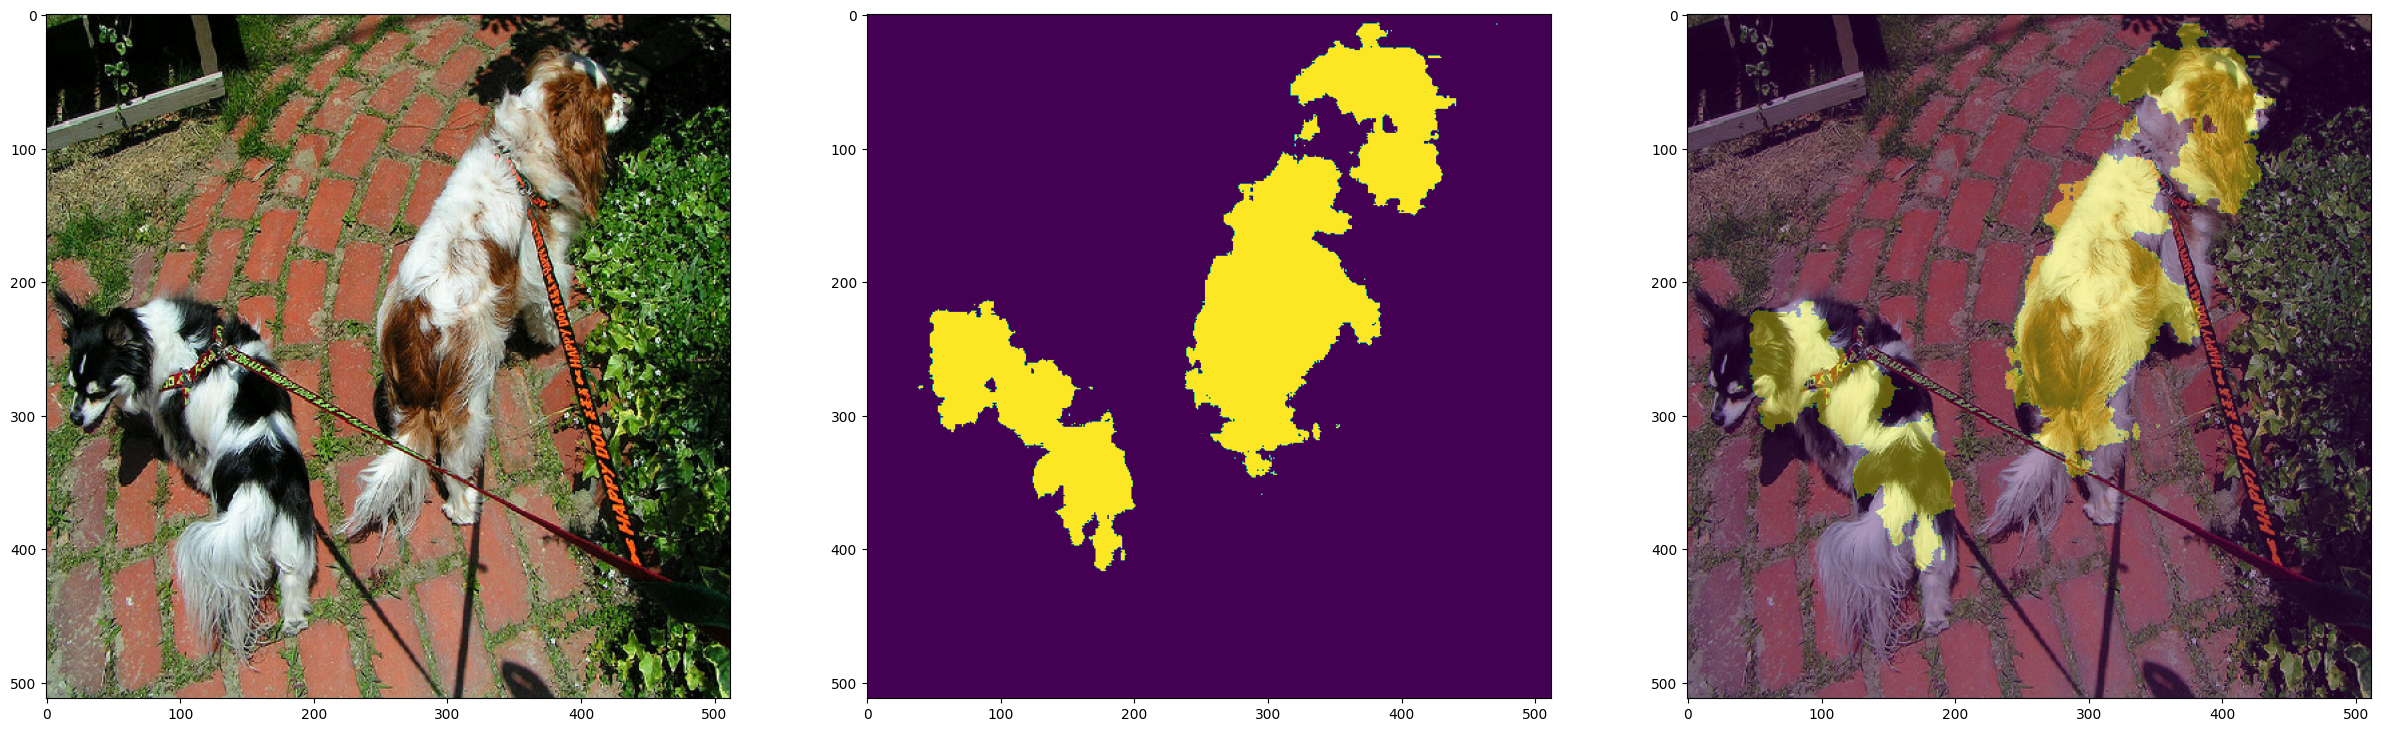

In [27]:
img = Image.open('data/dataset_firstTest/test/images/000000447200.jpg')
img = (np.array(img)/255).astype('float32')
resized_img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
resized_img_tensor = torch.tensor(resized_img).permute(2,0,1).unsqueeze(0)

with torch.no_grad():
    output = model(resized_img_tensor.to('cpu'))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(resized_img)
ax2.imshow(pred_mask.squeeze().cpu().numpy())
ax3.imshow(resized_img)
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)
plt.show()
